In [1]:
%autosave 0

Autosave disabled


In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.lite as tflite
import numpy as np

2022-11-27 19:18:01.291387: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#get the file dino-dragon
#!wget https://github.com/SVizor42/ML_Zoomcamp/releases/download/dino-dragon-model/dino_dragon_10_0.899.h5

In [4]:
model = keras.models.load_model('dino_dragon_10_0.899.h5')

2022-11-27 19:18:11.022222: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Question 1:

Now convert this model from Keras to TF-Lite format.

What's the size of the converted model?

- 21 Mb
- **43 Mb <----**
- 80 Mb
- 164 Mb

In [5]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open('dino_dragon.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/sr/7rmvrs4j3976bgrfblnbz1440000gn/T/tmp5ptkc49j/assets


INFO:tensorflow:Assets written to: /var/folders/sr/7rmvrs4j3976bgrfblnbz1440000gn/T/tmp5ptkc49j/assets
2022-11-27 19:18:14.817238: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-27 19:18:14.817261: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-27 19:18:14.818293: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/sr/7rmvrs4j3976bgrfblnbz1440000gn/T/tmp5ptkc49j
2022-11-27 19:18:14.820201: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-27 19:18:14.820220: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/sr/7rmvrs4j3976bgrfblnbz1440000gn/T/tmp5ptkc49j
2022-11-27 19:18:14.827377: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2022-11-27 19:18:14.829104: I tensorflow/cc/saved_model/load

## Question 2

To be able to use this model, we need to know the index of the input and the index of the output.

What's the output index for this model?

- 3
- 7
- **13 <----**
- 24

In [6]:
#load the model
interpreter = tflite.Interpreter(model_path='dino_dragon.tflite')

#load the weights
interpreter.allocate_tensors()

In [7]:
interpreter.get_input_details()

[{'name': 'serving_default_conv2d_input:0',
  'index': 0,
  'shape': array([  1, 150, 150,   3], dtype=int32),
  'shape_signature': array([ -1, 150, 150,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [8]:
input_index = interpreter.get_input_details()[0]['index']
input_index

0

In [9]:
interpreter.get_output_details()

[{'name': 'StatefulPartitionedCall:0',
  'index': 13,
  'shape': array([1, 1], dtype=int32),
  'shape_signature': array([-1,  1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [10]:
output_index = interpreter.get_output_details()[0]['index']
output_index

13

## Question 3

Now we need to turn the image into numpy array and pre-process it.

Tip: Check the previous homework. What was the pre-processing we did there?

After the pre-processing, what's the value in the first pixel, the R channel?

- 0.3353411
- **0.5529412 <---**
- 0.7458824
- 0.9654902

In [11]:
from io import BytesIO
from urllib import request

from PIL import Image

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

In [12]:
url='https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/Smaug_par_David_Demaret.jpg/1280px-Smaug_par_David_Demaret.jpg'
    

/var/folders/sr/7rmvrs4j3976bgrfblnbz1440000gn/T/ipykernel_6237/2487457277.py:17: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img = img.resize(target_size, Image.NEAREST)


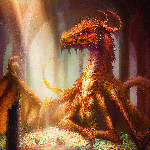

In [13]:
img=download_image(url)
img=prepare_image(img, target_size=(150,150))
img

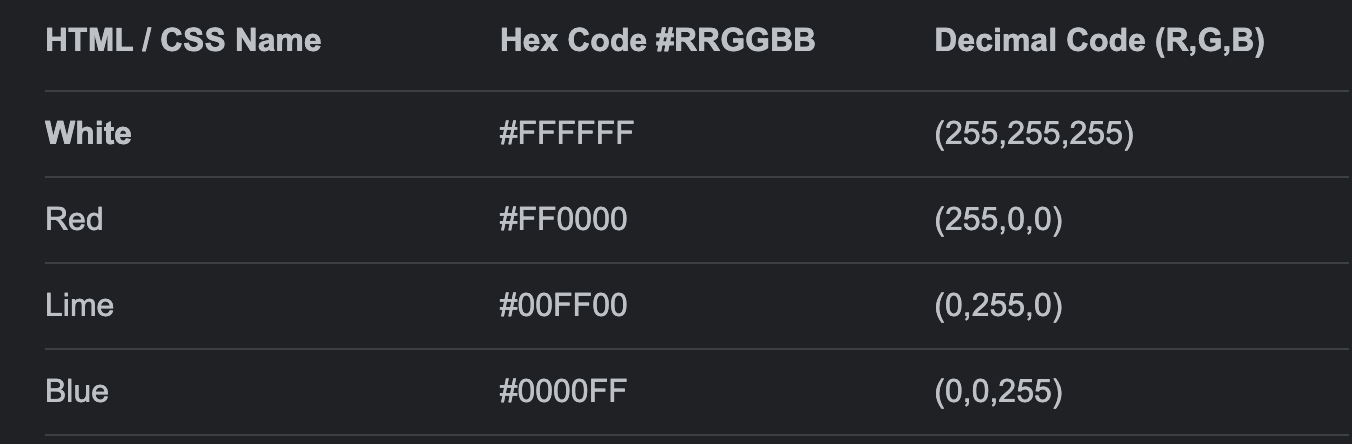

In [14]:
def prepare_input(x):
    return x / 255.0

In [15]:
x = np.array(img, dtype='float32')
x[0,0]

array([141.,  81.,  45.], dtype=float32)

In [16]:
X = np.array([x])
X = prepare_input(X)
X[0,0,0,0]

0.5529412

## Question 4

Now let's apply this model to this image. What's the output of the model?

- 0.17049132
- 0.39009996
- 0.60146114
- **0.82448614 <---***

In [17]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()

preds = interpreter.get_tensor(output_index)
preds

array([[0.8244865]], dtype=float32)

In [18]:
#!jupyter nbconvert --to script 'homework-9.ipynb'

## Question 5

Download the base image svizor42/zoomcamp-dino-dragon-lambda:v2. You can easily make it by using docker pull command.

So what's the size of this base image?

- 139 Mb
- 329 Mb
- **639 Mb <----**
- 929 Mb

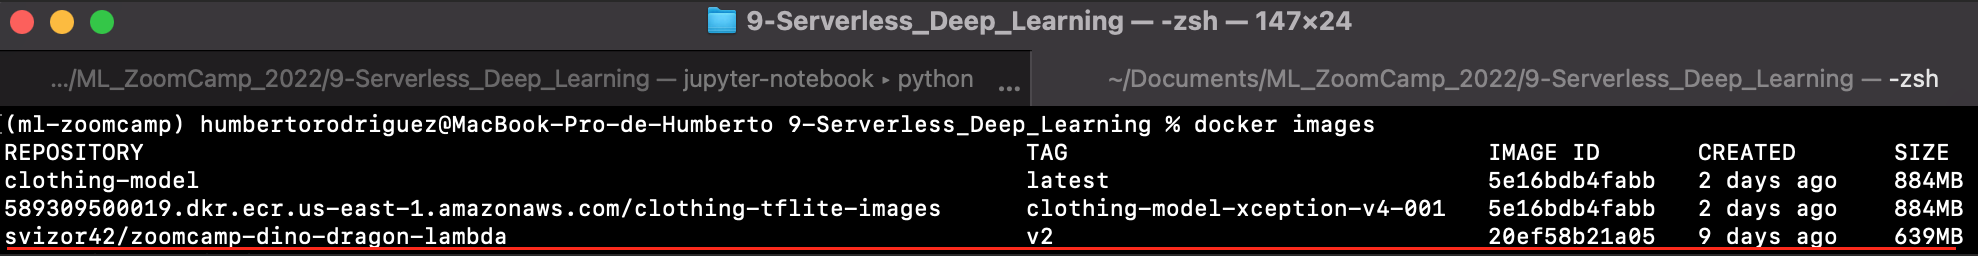